## Deep Convolutional Generative Adversarial Networks (DCGANs)

Deep Convolutional Generative Adversarial Networks (DCGANs) combine the power of deep convolutional neural networks (CNNs) with adversarial training to generate high-quality images from random noise. DCGANs have applications in image synthesis, style transfer, and data augmentation. In this tutorial, we explore DCGAN architecture and implementation, focusing on the popular MNIST dataset for digit generation.

Import Tensorflow and other libraries

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

Download MNIST Dataset

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [24]:
print("Length of train images = ", len(train_images))
print("Length of train labels = ", len(train_labels))
print("Train_mages shape = ", train_images.shape)
print("Data type = ", train_images.dtype)

Length of train images =  60000
Length of train labels =  60000
Train_mages shape =  (60000, 28, 28, 1)
Data type =  float32


Convolutional neural networks (CNNs) typically expect input data in the shape of [batch_size, height, width, channels]. Reshaping allows to rearrange the dimensions of the dataset to match the required input shape.

In [25]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) #.astype('float32')
print("Train_mages new shape = ", train_images.shape)
print("Data type = ", train_images.dtype)

Train_mages new shape =  (60000, 28, 28, 1)
Data type =  float32


 BUFFER_SIZE typically refers to the number of elements (samples) from the dataset that should be buffered (or shuffled) at a time. When you're dealing with large datasets that cannot fit entirely into memory, you can't shuffle the entire dataset at once. Instead, you shuffle a buffer of elements. Setting the BUFFER_SIZE parameter controls the size of this buffer. A larger buffer size allows for more effective shuffling but requires more memory.

 BATCH_SIZE refers to the number of samples that are propagated through the neural network in a single forward/backward pass. In other words, it's the number of samples processed before the model's parameters are updated. Using mini-batches instead of processing the entire dataset at once helps in reducing the memory usage and allows for faster training as computations can be parallelized across the batch.

In [32]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

tf.data.Dataset.from_tensor_slices(train_images): 
>This creates a TensorFlow dataset from the train_images data. The train_images variable is a tensor/array containing the training data. Each element of train_images is treated as a separate sample along the first dimension.

.shuffle(BUFFER_SIZE): 
> This shuffles the elements of the dataset with a buffer size of BUFFER_SIZE. Shuffling the dataset is important during training to prevent the model from learning spurious correlations due to the order of the training data. The BUFFER_SIZE parameter determines the number of elements from which the dataset is shuffled at once. A larger buffer size allows for more effective shuffling but requires more memory.

.batch(BATCH_SIZE): 
> This groups the elements of the dataset into batches of size BATCH_SIZE. Batching is done to improve computational efficiency by processing multiple samples in parallel. The BATCH_SIZE parameter specifies the number of elements in each batch.

### Create the models

#### The Generator

In [36]:
def make_generator_model():
    ###--- Model Creation ---###
    model = tf.keras.Sequential()
    # This initializes a sequential model, which is a linear stack of layers.
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # This adds a dense (fully connected) layer to the model with 7*7*256 neurons (flattened to a 2D array).
    #-- The input shape for this layer is (100,), indicating that it takes a 100-dimensional input vector.
    #-- This likely receives a 100-dimensional noise vector as input.
    #--- The 'use_bias=False' argument skips adding a bias term which can improve performance in certain GAN scenarios.
    model.add(layers.BatchNormalization())
    # This adds a batch normalization layer. 
    #- Batch normalization normalizes the activations of the previous layer at each batch, helping the training process.
    #-- improving training stability.
    model.add(layers.LeakyReLU())
    # This adds a Leaky ReLU activation function.
    #- allows a small, non-zero gradient when the unit is not active, which helps prevent the "dying ReLU" problem.
    #-- allowing small non-zero gradients even for negative inputs.
    model.add(layers.Reshape((7, 7, 256)))
    # This reshapes the output of the previous layer into a 3D tensor with shape (7, 7, 256).
    #- likely representing a feature map.
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    # This assertion checks if the shape of the output tensor is as expected.
    
    ###--- Deconvolutional layers ---###
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Conv2DTranspose - essentially deconvolutional (transposed convolutional) layers that upsample the spatial dimensions of the feature map.
    #-  with 128 filters, a kernel size of (5, 5), and a stride of (1, 1). 
    #-- The padding is set to 'same': ensures the output size remains the same after convolution.
    #--- bias usage is set to False.
    assert model.output_shape == (None, 7, 7, 128)
    # checks the shape of the output tensor after adding the convolutional layer.
    model.add(layers.BatchNormalization())
    # Adds another batch normalization layer.
    model.add(layers.LeakyReLU())
    # Leaky ReLU continues to be used as the activation function.

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Conv2DTranspose - essentially deconvolutional (transposed convolutional) layers that upsample the spatial dimensions of the feature map.
    #-  with 64 filters, a kernel size of (5, 5), and a stride of (2, 2). 
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    # Adds another batch normalization layer.
    model.add(layers.LeakyReLU())
    # Leaky ReLU continues to be used as the activation function.

    ###--- Final layer ---###
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # adds a transposed convolutional layer with a single filter (as the output should be grayscale),
    #- a kernel size of (5, 5), a stride of (2, 2) for upsampling and 'tanh' activation function.
    #-- Tanh is used to ensure the output values are in the range [-1, 1], suitable for image pixel values.
    assert model.output_shape == (None, 28, 28, 1)
    # checks the final shape of the output tensor, ensuring it has the desired dimensions for a 28x28 grayscale image.

    return model

This generator model takes a 100-dimensional noise vector as input and generates a 28x28 grayscale image as output. It gradually upsamples the input noise through transposed convolutional layers (deconvolutional layers), batch normalization, and activation functions to produce an image that resembles the training data.

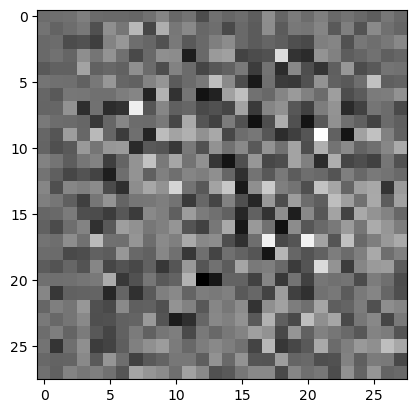

In [38]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
# It generates 100 random numbers using the normal distribution (mean=0, standard deviation=1).
#- These numbers are then placed in a single array (tensor) with a shape of [1, 100].
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# Display the image

#### The Discriminator

In [39]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [40]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00199609]], shape=(1, 1), dtype=float32)


#### Define the loss and optimizers

Define loss functions and optimizers for both models.

In [41]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator loss

In [42]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [43]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [44]:
#The discriminator and the generator optimizers are different since you will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [45]:
# Save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Define the training loop

In [50]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [46]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [47]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Generate and save images

In [48]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### Train the model

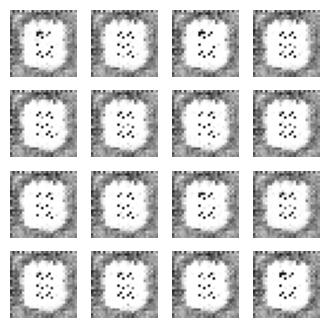

Time for epoch 3 is 147.94178366661072 sec


KeyboardInterrupt: 

In [51]:
train(train_dataset, EPOCHS)

In [53]:
print(tf.config.list_physical_devices('GPU'))

[]
